<a href="https://colab.research.google.com/github/tfitzpatrick0/CV-FaceRecognition/blob/main/signature_recognition_snn_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow torch numpy gunicorn scipy sklearn pillow matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=b5e81f67643ba84f2b1e864c2195d21c9f75436883d6764c83d8ffd9ec1431b1
  Stored in directory: /root/.cache/pip/wheels/46/b8/69/4f7789b7d2fc0718a44cbc4ae5d40970a40c22c472ae50f0a1
Successfully built sklearn


In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Input, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# For this Siamese Neural Network, we are using the BHSig260 Hindi Dataset. The link to the dataset is [Kaggle BHSig260](www.kaggle.com/datasets/ishanikathuria/handwritten-signature-datasets?resource=download)

### After downloading the dataset, create a google drive folder called SignatureVerification, and move the Hindi dataset into the folder. After this, create another directory within SignatureVerification/ called Weights to save the future model during training.

In [3]:
# Set the path to the directory containing the signature dataset
data_path = "/content/gdrive/My Drive/SignatureVerification/Hindi/"

# Get a list of all subdirectories in the folder
dir_list = [f.path for f in os.scandir(data_path) if f.is_dir()]
dir_list.sort()

# Define a function to load the images --> MIGHT NOT NEED
def load_image(path):
    img = load_img(path, target_size=(155, 220), color_mode='grayscale')
    img = img_to_array(img)
    img = img.astype('float32') / 255.0
    return img

# Create empty lists to hold the genuine and forged signatures
forged_images = []
genuine_images = []

n = 0

for person in dir_list:
  print(person)

  images = os.listdir(person)
  images.sort
  images = [person+'/'+x for x in images]

  curr_forged_images = []
  curr_genuine_images = []

  if (len(images) == 54):
    for image in images:
      if "-F-" in image:
        curr_forged_images.append(image)
      else:
        curr_genuine_images.append(image)

    forged_images.append(curr_forged_images)
    genuine_images.append(curr_genuine_images)

/content/gdrive/My Drive/SignatureVerification/Hindi/001
/content/gdrive/My Drive/SignatureVerification/Hindi/002
/content/gdrive/My Drive/SignatureVerification/Hindi/003
/content/gdrive/My Drive/SignatureVerification/Hindi/004
/content/gdrive/My Drive/SignatureVerification/Hindi/005
/content/gdrive/My Drive/SignatureVerification/Hindi/006
/content/gdrive/My Drive/SignatureVerification/Hindi/007
/content/gdrive/My Drive/SignatureVerification/Hindi/008
/content/gdrive/My Drive/SignatureVerification/Hindi/009
/content/gdrive/My Drive/SignatureVerification/Hindi/010
/content/gdrive/My Drive/SignatureVerification/Hindi/011
/content/gdrive/My Drive/SignatureVerification/Hindi/012
/content/gdrive/My Drive/SignatureVerification/Hindi/013
/content/gdrive/My Drive/SignatureVerification/Hindi/014
/content/gdrive/My Drive/SignatureVerification/Hindi/015
/content/gdrive/My Drive/SignatureVerification/Hindi/016
/content/gdrive/My Drive/SignatureVerification/Hindi/017
/content/gdrive/My Drive/Signat

In [4]:
print(len(genuine_images), len(forged_images))
print(genuine_images[0])

# Set the percentage split for training, validation, and testing
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

# Split the genuine signatures into training, validation, and testing groups
genuine_train = genuine_images[:int(len(genuine_images)*train_percent)]
genuine_val = genuine_images[int(len(genuine_images)*train_percent):int(len(genuine_images)*(train_percent+val_percent))]
genuine_test = genuine_images[int(len(genuine_images)*(train_percent+val_percent)):]
print(len(genuine_train), len(genuine_val), len(genuine_test))

# Split the forged signatures into training, validation, and testing groups
forged_train = forged_images[:int(len(forged_images)*train_percent)]
forged_val = forged_images[int(len(forged_images)*train_percent):int(len(forged_images)*(train_percent+val_percent))]
forged_test = forged_images[int(len(forged_images)*(train_percent+val_percent)):]
print(len(forged_train), len(forged_val), len(forged_test))

155 155
['/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-14.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-08.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-16.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-22.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-17.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-12.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-04.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-07.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-02.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-03.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-24.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-06.tif', '/content/gdrive/My Drive/SignatureVerification/Hindi/001/H-S-1-G-13.tif', '/content/gdrive

In [5]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [6]:
# Use matplotlib to display two genuine copies of a signature and a forged copy from the same person
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(genuine_train))
    orig_img_names = random.sample(genuine_train[k], 2)
    forg_img_name = random.sample(forged_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

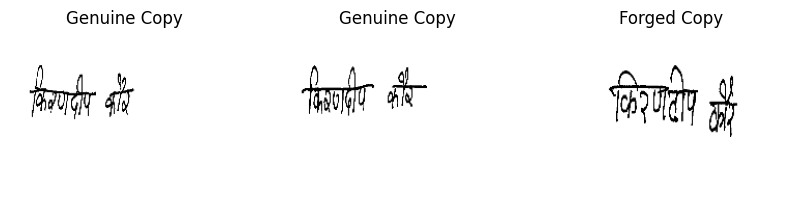

In [7]:
visualize_sample_signature()

In [8]:
def euclidean_distance(vectors):
  # Calculate euclidean distance between vectors
  vector1, vector2 = vectors
  sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [15]:
def create_siamese_network(input_shape):
    # Base Siamese Network
    print(input_shape)

    # Input Layers
    input_layer_1 = Input(input_shape)
    input_layer_2 = Input(input_shape)

    seq = Sequential()
    seq.add(Convolution2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    seq.add(MaxPooling2D(pool_size=(2,2)))
    seq.add(Convolution2D(64, kernel_size=(3,3), activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2,2)))
    seq.add(Convolution2D(64, kernel_size=(3, 3), activation='relu'))
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dense(64, activation='relu'))
    seq.add(Dense(32, activation='relu'))

    # Apply the base network to each input layer to get a left and right side
    # of the siamese network
    encoded_l = seq(input_layer_1)
    encoded_r = seq(input_layer_2)

    # Calculate the distance between outputs to adjust weights
    distance = Lambda(euclidean_distance)([encoded_l, encoded_r])

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(distance)
    siamese_network = Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer) 

    return siamese_network

In [10]:
def contrastive_loss(y_true, y_pred):
  margin = 1
  return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [11]:
input_shape = (img_h, img_w, 1)

siamese_net = create_siamese_network(input_shape)
siamese_net.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy'])

(155, 220, 1)


In [12]:
def generate_pairs(genuine_group, forged_group, batch_size):

  while True:
    genuine_pairs, forged_pairs = [], []
    gen_gen_labels, gen_forg_labels = [], []
    all_pairs, all_labels = [], []

    for genuine, forged in zip(genuine_group, forged_group):
      genuine_pairs.extend(list(itertools.combinations(genuine, 2)))

      for i in range(len(forged)):
        forged_pairs.extend(list(itertools.product(genuine[i:i+1], random.sample(forged, 12))))

    gen_gen_labels = [1]*len(genuine_pairs)
    gen_forg_labels = [0]*len(forged_pairs)

    all_pairs = genuine_pairs + forged_pairs
    all_labels = gen_gen_labels + gen_forg_labels
    all_pairs, all_labels = shuffle(all_pairs, all_labels)

    pairs = [np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
    labels = np.zeros((batch_size,))
    counter = 0

    for idx, pair in enumerate(all_pairs):
      img1 = cv2.imread(pair[0], 0)
      img2 = cv2.imread(pair[1], 0)

      img1 = cv2.resize(img1, (img_w, img_h))
      img2 = cv2.resize(img2, (img_w, img_h))

      img1 = np.array(img1, dtype=np.float64)
      img2 = np.array(img2, dtype=np.float64)

      img1 /= 255
      img2 /= 255

      img1 = img1[..., np.newaxis]
      img2 = img2[..., np.newaxis]

      pairs[0][counter, :, :, :] = img1
      pairs[1][counter, :, :, :] = img2
      labels[counter] = all_labels[idx]
      counter += 1

      if counter == batch_size:
        yield pairs, labels
        counter = 0
        pairs = [np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        labels = np.zeros((batch_size,))

In [13]:
batch_sz = 128
num_train_samples = 276*len(genuine_train) + 300*len(forged_train)
num_val_samples = num_test_samples = 276*len(genuine_val) + 300*len(forged_val)
num_train_samples, num_val_samples, num_test_samples

(62208, 13248, 13248)

In [14]:
# Save the model after every epoch
# Reduce the learning rate if the validation loss does not improve for 2 epochs
# Stop the training early if the validation loss does not improve for 5 epochs
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/SignatureVerification/Weights/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

results = siamese_net.fit(
    generate_pairs(genuine_train, forged_train, batch_size=batch_sz),
    steps_per_epoch = (num_train_samples//batch_sz) // 8,
    validation_data = generate_pairs(genuine_val, forged_val, batch_size=batch_sz),
    validation_steps = (num_val_samples//batch_sz) // 8,
    epochs = 15,
    callbacks = callbacks
)

Epoch 1/15
60/60 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5026 
Epoch 1: saving model to /content/drive/MyDrive/SignatureVerification/Weights/signet-bhsig260-001.h5
60/60 [==============================] - 2573s 43s/step - loss: 0.6930 - accuracy: 0.5026 - val_loss: 0.6945 - val_accuracy: 0.4915 - lr: 1.0000e-04
Epoch 2/15
28/60 [=============>................] - ETA: 10:11 - loss: 0.6925 - accuracy: 0.4944

KeyboardInterrupt: ignored

##### Load the weights from google drive at the epoch where training most recently saved a model. In this case it was epoch 5 (005). For example if training completes all 15 epochs it would be epoch 15 (015)

In [ ]:
# The path to the model is '/content/drive/MyDrive/SignatureVerification/Weights/signet-bhsig260-{epoch}.h5'
# Replace {epoch} with the final epoch of the model that is being loaded from google drive

siamese_net.load_weights('/content/drive/MyDrive/SignatureVerification/Weights/signet-bhsig260-010.h5')

FileNotFoundError: ignored

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [ ]:
test_gen = generate_pairs(genuine_test, forged_test, 1)
pred, tr_y = [], []

for i in range(100):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(siamese_net.predict([img1, img2])[0][0])

1/1 [==============================] - 0s 52ms/step


In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.7282828282828282, 0.4913495087623596)

In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    if test_label == 1:
      print("SIGNATURE IS GENUINE")
    else:
      print("SIGNATURE IS FORGED")

    result = siamese_net.predict([img1, img2], verbose=0)
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Prediction - Its a Forged Signature")
    else:
        print("Prediction - Its a Genuine Signature")

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

In [ ]:
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()
predict_score()

SIGNATURE IS GENUINE
Difference Score =  0.6133562
Prediction - Its a Forged Signature
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SIGNATURE IS FORGED
Difference Score =  0.037037257
Prediction - Its a Genuine Signature
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SIGNATURE IS FORGED
Difference Score =  0.59784895
Prediction - Its a Forged Signature
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SIGNATURE IS FORGED
Difference Score =  0.82632893
Prediction - Its a Forged Signature
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SIGNATURE IS FORGED
Difference Score =  0.78000623
Prediction - Its a Forged Signature
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SIGNATURE IS GENUINE
Difference Score =  0.65782857
Prediction - Its a Forged Signature
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SIGNATURE IS FORGED
Difference Score =  0.119044304
Prediction - Its a Genuine Signature
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SIGNATURE IS FORGED
Difference Score =  0.6396962
Prediction - Its a Forged Signature
~~~~~~~~~~~~~